In [1]:
import os
import numpy as np 
import pandas as pd 
from skimage.io import imread
import glob
import argparse
import os
import sys
import datetime
import time
import math
import json
from pathlib import Path

import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.distributed as dist
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision import models as torchvision_models
import utils
import vision_transformer as vits
from vision_transformer import DINOHead

from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/')

In [3]:
#! git clone https://github.com/facebookresearch/dino.git

In [5]:
class DataAugmentationDINO(object):
    def __init__(self, global_crops_scale, local_crops_scale, local_crops_number):
        flip_and_color_jitter = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
        ])
        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

        # first global crop
        self.global_transfo1 = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=global_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(1.0),
            normalize,
        ])
        # second global crop
        self.global_transfo2 = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=global_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(0.1),
            utils.Solarization(0.2),
            normalize,
        ])
        # transformation for the local small crops
        self.local_crops_number = local_crops_number
        self.local_transfo = transforms.Compose([
            transforms.RandomResizedCrop(96, scale=local_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(p=0.5),
            normalize,
        ])

    def __call__(self, image):
        crops = []
        crops.append(self.global_transfo1(image))
        crops.append(self.global_transfo2(image))
        for _ in range(self.local_crops_number):
            crops.append(self.local_transfo(image))
        return crops

In [6]:
class DINOLoss(nn.Module):
    def __init__(self, out_dim, ncrops, warmup_teacher_temp, teacher_temp,
                 warmup_teacher_temp_epochs, nepochs, student_temp=0.1,
                 center_momentum=0.9):
        super().__init__()
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.ncrops = ncrops
        self.register_buffer("center", torch.zeros(1, out_dim))
        # we apply a warm up for the teacher temperature because
        # a too high temperature makes the training instable at the beginning
        self.teacher_temp_schedule = np.concatenate((
            np.linspace(warmup_teacher_temp,
                        teacher_temp, warmup_teacher_temp_epochs),
            np.ones(nepochs - warmup_teacher_temp_epochs) * teacher_temp
        ))

    def forward(self, student_output, teacher_output, epoch):
        """
        Cross-entropy between softmax outputs of the teacher and student networks.
        """
        student_out = student_output / self.student_temp
        student_out = student_out.chunk(self.ncrops)

        # teacher centering and sharpening
        temp = self.teacher_temp_schedule[epoch]
        teacher_out = F.softmax((teacher_output - self.center) / temp, dim=-1)
        teacher_out = teacher_out.detach().chunk(2)

        total_loss = 0
        n_loss_terms = 0
        for iq, q in enumerate(teacher_out):
            for v in range(len(student_out)):
                if v == iq:
                    # we skip cases where student and teacher operate on the same view
                    continue
                loss = torch.sum(-q * F.log_softmax(student_out[v], dim=-1), dim=-1)
                total_loss += loss.mean()
                n_loss_terms += 1
        total_loss /= n_loss_terms
        self.update_center(teacher_output)
        return total_loss
        
    @torch.no_grad()
    def update_center(self, teacher_output):
        """
        Update center used for teacher output.
        """
        batch_center = torch.sum(teacher_output, dim=0, keepdim=True)
        dist.all_reduce(batch_center)
        batch_center = batch_center / (len(teacher_output) * dist.get_world_size())

        # ema update
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)



In [6]:
def train_dino(args):
    init_distributed_mode(args)
    utils.fix_random_seeds(args['seed'])
    print("git:\n  {}\n".format(utils.get_sha()))
    #print("\n".join("%s: %s" % (k, str(v)) for k, v in sorted(dict(vars(args)).items())))
    cudnn.benchmark = True

    # ============ preparing data ... ============
    transform = DataAugmentationDINO(
        args['global_crops_scale'],
        args['local_crops_scale'],
        args['local_crops_number'],
    )
    dataset = datasets.ImageFolder(args['data_path'], transform=transform)
    sampler = torch.utils.data.DistributedSampler(dataset, shuffle=True)
    data_loader = torch.utils.data.DataLoader(
        dataset,
        sampler=sampler,
        batch_size=args['batch_size_per_gpu'],
        num_workers=args['num_workers'],
        pin_memory=True,
        drop_last=True,
    )
    print(f"Data loaded: there are {len(dataset)} images.")

    # ============ building student and teacher networks ... ============
    # we changed the name DeiT-S for ViT-S to avoid confusions
    args['arch'] = args['arch'].replace("deit", "vit")
    # if the network is a Vision Transformer (i.e. vit_tiny, vit_small, vit_base)
    if args['arch'] in vits.__dict__.keys():
        student = vits.__dict__[args['arch']](
            patch_size=args['patch_size'],
            drop_path_rate=args['drop_path_rate'],  # stochastic depth
        )
        teacher = vits.__dict__[args['arch']](patch_size=args['patch_size'])
        embed_dim = student.embed_dim
    # if the network is a XCiT
    elif args['arch'] in torch.hub.list("facebookresearch/xcit:main"):
        student = torch.hub.load('facebookresearch/xcit:main', args['arch'],
                                 pretrained=False, drop_path_rate=args['drop_path_rate'])
        teacher = torch.hub.load('facebookresearch/xcit:main', args['arch'], pretrained=False)
        embed_dim = student.embed_dim
    # otherwise, we check if the architecture is in torchvision models
    elif args['arch'] in torchvision_models.__dict__.keys():
        student = torchvision_models.__dict__[args['arch']]()
        teacher = torchvision_models.__dict__[args['arch']]()
        embed_dim = student.fc.weight.shape[1]
    else:
        print(f"Unknow architecture: {args['arch']}")

    # multi-crop wrapper handles forward with inputs of different resolutions
    student = utils.MultiCropWrapper(student, DINOHead(
        embed_dim,
        args['out_dim'],
        use_bn=args['use_bn_in_head'],
        norm_last_layer=args['norm_last_layer'],
    ))
    teacher = utils.MultiCropWrapper(
        teacher,
        DINOHead(embed_dim, args['out_dim'], args['use_bn_in_head']),
    )
    # move networks to gpu
    student, teacher = student.cuda(), teacher.cuda()
    # synchronize batch norms (if any)
    if utils.has_batchnorms(student):
        student = nn.SyncBatchNorm.convert_sync_batchnorm(student)
        teacher = nn.SyncBatchNorm.convert_sync_batchnorm(teacher)

        # we need DDP wrapper to have synchro batch norms working...
        teacher = nn.parallel.DistributedDataParallel(teacher, device_ids=[args['gpu']])
        teacher_without_ddp = teacher.module
    else:
        # teacher_without_ddp and teacher are the same thing
        teacher_without_ddp = teacher
    student = nn.parallel.DistributedDataParallel(student, device_ids=[args['gpu']])
    # teacher and student start with the same weights
    teacher_without_ddp.load_state_dict(student.module.state_dict())
    # there is no backpropagation through the teacher, so no need for gradients
    for p in teacher.parameters():
        p.requires_grad = False
    print(f"Student and Teacher are built: they are both {args['arch']} network.")

    # ============ preparing loss ... ============
    dino_loss = DINOLoss(
        args['out_dim'],
        args['local_crops_number'] + 2,  # total number of crops = 2 global crops + local_crops_number
        args['warmup_teacher_temp'],
        args['teacher_temp'],
        args['warmup_teacher_temp_epochs'],
        args['epochs'],
    ).cuda()

    # ============ preparing optimizer ... ============
    params_groups = utils.get_params_groups(student)
    if args['optimizer'] == "adamw":
        optimizer = torch.optim.AdamW(params_groups)  # to use with ViTs
    elif args['optimizer'] == "sgd":
        optimizer = torch.optim.SGD(params_groups, lr=0, momentum=0.9)  # lr is set by scheduler
    elif args['optimizer'] == "lars":
        optimizer = utils.LARS(params_groups)  # to use with convnet and large batches
    # for mixed precision training
    fp16_scaler = None
    if args['use_fp16']:
        fp16_scaler = torch.cuda.amp.GradScaler()

    # ============ init schedulers ... ============
    lr_schedule = utils.cosine_scheduler(
        args['lr'] * (args['batch_size_per_gpu'] * utils.get_world_size()) / 256.,  # linear scaling rule
        args['min_lr'],
        args['epochs'], len(data_loader),
        warmup_epochs=args['warmup_epochs'],
    )
    wd_schedule = utils.cosine_scheduler(
        args['weight_decay'],
        args['weight_decay_end'],
        args['epochs'], len(data_loader),
    )
    # momentum parameter is increased to 1. during training with a cosine schedule
    momentum_schedule = utils.cosine_scheduler(args['momentum_teacher'], 1,
                                               args['epochs'], len(data_loader))
    print(f"Loss, optimizer and schedulers ready.")

    # ============ optionally resume training ... ============
    to_restore = {"epoch": 0}
    utils.restart_from_checkpoint(
        os.path.join(args['output_dir'], "checkpoint.pth"),
        run_variables=to_restore,
        student=student,
        teacher=teacher,
        optimizer=optimizer,
        fp16_scaler=fp16_scaler,
        dino_loss=dino_loss,
    )
    start_epoch = to_restore["epoch"]

    start_time = time.time()
    print("Starting DINO training !")
    for epoch in range(start_epoch, args['epochs']):
        data_loader.sampler.set_epoch(epoch)

        # ============ training one epoch of DINO ... ============
        train_stats = train_one_epoch(student, teacher, teacher_without_ddp, dino_loss,
            data_loader, optimizer, lr_schedule, wd_schedule, momentum_schedule,
            epoch, fp16_scaler, args)

        # ============ writing logs ... ============
        save_dict = {
            'student': student.state_dict(),
            'teacher': teacher.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch + 1,
            'args': args,
            'dino_loss': dino_loss.state_dict(),
        }
        if fp16_scaler is not None:
            save_dict['fp16_scaler'] = fp16_scaler.state_dict()
        utils.save_on_master(save_dict, os.path.join(args['output_dir'], 'checkpoint.pth'))
        if args['saveckp_freq'] and epoch % args['saveckp_freq'] == 0:
            utils.save_on_master(save_dict, os.path.join(args['output_dir'], f'checkpoint{epoch:04}.pth'))
        log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                     'epoch': epoch}
        if utils.is_main_process():
            with (Path(args['output_dir']) / "log.txt").open("a") as f:
                f.write(json.dumps(log_stats) + "\n")
    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print('Training time {}'.format(total_time_str))


def train_one_epoch(student, teacher, teacher_without_ddp, dino_loss, data_loader,
                    optimizer, lr_schedule, wd_schedule, momentum_schedule,epoch,
                    fp16_scaler, args):
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Epoch: [{}/{}]'.format(epoch, args['epochs'])
    for it, (images, _) in enumerate(metric_logger.log_every(data_loader, 10, header)):
        # update weight decay and learning rate according to their schedule
        it = len(data_loader) * epoch + it  # global training iteration
        for i, param_group in enumerate(optimizer.param_groups):
            param_group["lr"] = lr_schedule[it]
            if i == 0:  # only the first group is regularized
                param_group["weight_decay"] = wd_schedule[it]

        # move images to gpu
        images = [im.cuda(non_blocking=True) for im in images]
        # teacher and student forward passes + compute dino loss
        with torch.cuda.amp.autocast(fp16_scaler is not None):
            teacher_output = teacher(images[:2])  # only the 2 global views pass through the teacher
            student_output = student(images)
            loss = dino_loss(student_output, teacher_output, epoch)

        if not math.isfinite(loss.item()):
            print("Loss is {}, stopping training".format(loss.item()), force=True)
            sys.exit(1)

        # student update
        optimizer.zero_grad()
        param_norms = None
        if fp16_scaler is None:
            loss.backward()
            if args['clip_grad']:
                param_norms = utils.clip_gradients(student, args['clip_grad'])
            utils.cancel_gradients_last_layer(epoch, student,
                                              args['freeze_last_layer'])
            optimizer.step()
        else:
            fp16_scaler.scale(loss).backward()
            if args['clip_grad']:
                fp16_scaler.unscale_(optimizer)  # unscale the gradients of optimizer's assigned params in-place
                param_norms = utils.clip_gradients(student, args['clip_grad'])
            utils.cancel_gradients_last_layer(epoch, student,
                                              args['freeze_last_layer'])
            fp16_scaler.step(optimizer)
            fp16_scaler.update()

        # EMA update for the teacher
        with torch.no_grad():
            m = momentum_schedule[it]  # momentum parameter
            for param_q, param_k in zip(student.module.parameters(), teacher_without_ddp.parameters()):
                param_k.data.mul_(m).add_((1 - m) * param_q.detach().data)

        # logging
        torch.cuda.synchronize()
        metric_logger.update(loss=loss.item())
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        metric_logger.update(wd=optimizer.param_groups[0]["weight_decay"])
    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}



    @torch.no_grad()
    def update_center(self, teacher_output):
        """
        Update center used for teacher output.
        """
        batch_center = torch.sum(teacher_output, dim=0, keepdim=True)
        dist.all_reduce(batch_center)
        batch_center = batch_center / (len(teacher_output) * dist.get_world_size())

        # ema update
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)



In [7]:
def init_distributed_mode(args):
    # launched with torch.distributed.launch
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args['rank'] = int(os.environ["RANK"])
        args['world_size'] = int(os.environ['WORLD_SIZE'])
        args['gpu'] = int(os.environ['LOCAL_RANK'])
    # launched with submitit on a slurm cluster
    elif 'SLURM_PROCID' in os.environ:
        args['rank'] = int(os.environ['SLURM_PROCID'])
        args['gpu'] = args['rank'] % torch.cuda.device_count()
    # launched naively with `python main_dino.py`
    # we manually add MASTER_ADDR and MASTER_PORT to env variables
    elif torch.cuda.is_available():
        print('Will run the code on one GPU.')
        args['rank'], args['gpu'], args['world_size'] = 0, 0, 1
        os.environ['MASTER_ADDR'] = '127.0.0.1'
        os.environ['MASTER_PORT'] = '29500'
    else:
        print('Does not support training without GPU.')
        sys.exit(1)

    dist.init_process_group(
        backend="nccl",
        init_method=args['dist_url'],
        world_size=args['world_size'],
        rank=args['rank'],
    )

    torch.cuda.set_device(args['gpu'])
    print('| distributed init (rank {}): {}'.format(
        args['rank'], args['dist_url']), flush=True)
    dist.barrier()
    setup_for_distributed(args['rank'] == 0)
    
def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print

In [8]:
# Model parameters
d = {'arch' : 'vit_tiny',   #['vit_tiny', 'vit_small', 'vit_base', 'xcit', 'deit_tiny', 'deit_small'] \ 
  'patch_size': 16, 
  'out_dim':65536,
  'norm_last_layer':True,
  'momentum_teacher':0.996,
  'use_bn_in_head': False,

  # Temperature teacher parameters
  'warmup_teacher_temp':0.04,
  'teacher_temp':0.04,
  'warmup_teacher_temp_epochs':0,

  # Training/Optimization parameters
  'use_fp16':True,
  'weight_decay':0.04,
  'weight_decay_end':0.4,
  'clip_grad':3.0,
  'batch_size_per_gpu':8, ####
  'epochs':60,
  'freeze_last_layer':1,
  'lr':0.0005,
  'warmup_epochs':10,
  'min_lr':1e-6,
  'optimizer':'adamw', #choices=['adamw', 'sgd', 'lars'], help="""Type of optimizer. We recommend using adamw with ViTs.""")
  'drop_path_rate':0.1,

  # Multi-crop parameters
  'global_crops_scale':(0.4, 1.),
  'local_crops_number':8,
  'local_crops_scale':(0.05, 0.4),

  # Misc
  'data_path':'/content/drive/MyDrive/predicted_patches/',
  'output_dir':'/content/drive/MyDrive/output_dino/',
  'saveckp_freq':20,
  'seed':0,
  'num_workers':10,
  'dist_url': 'env://',
  'local_rank':0 }

In [9]:
train_dino(d)

Will run the code on one GPU.
| distributed init (rank 0): env://
git:
  sha: cb711401860da580817918b9167ed73e3eef3dcf, status: has uncommited changes, branch: main



/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:891: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded: there are 3829 images.
Student and Teacher are built: they are both vit_tiny network.
Loss, optimizer and schedulers ready.
Found checkpoint at /content/drive/MyDrive/output_dino/checkpoint.pth
=> loaded 'student' from checkpoint '/content/drive/MyDrive/output_dino/checkpoint.pth' with msg <All keys matched successfully>
=> loaded 'teacher' from checkpoint '/content/drive/MyDrive/output_dino/checkpoint.pth' with msg <All keys matched successfully>
=> loaded 'optimizer' from checkpoint: '/content/drive/MyDrive/output_dino/checkpoint.pth'
=> loaded 'fp16_scaler' from checkpoint: '/content/drive/MyDrive/output_dino/checkpoint.pth'
=> loaded 'dino_loss' from checkpoint '/content/drive/MyDrive/output_dino/checkpoint.pth' with msg <All keys matched successfully>
Starting DINO training !
Epoch: [23/60]  [  0/478]  eta: 0:44:30  loss: 9.719910 (9.719910)  lr: 0.000013 (0.000013)  wd: 0.155494 (0.155494)  time: 5.585896  data: 4.168596  max mem: 1443
Epoch: [23/60]  [ 10/478]  eta:

## Adaptation of attention map visualization

In [8]:
# Copyright (c) Facebook, Inc. and its affiliates.
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     http://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import os
import sys
import argparse
import cv2
import random
import colorsys
import requests
from io import BytesIO

import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

import utils
import vision_transformer as vits


def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image


def random_colors(N, bright=True):
    """
    Generate random colors.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def display_instances(image, mask, fname="test", figsize=(5, 5), blur=False, contour=True, alpha=0.5):
    fig = plt.figure(figsize=figsize, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax = plt.gca()

    N = 1
    mask = mask[None, :, :]
    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    margin = 0
    ax.set_ylim(height + margin, -margin)
    ax.set_xlim(-margin, width + margin)
    ax.axis('off')
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        _mask = mask[i]
        if blur:
            _mask = cv2.blur(_mask,(10,10))
        # Mask
        masked_image = apply_mask(masked_image, _mask, color, alpha)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        if contour:
            padded_mask = np.zeros((_mask.shape[0] + 2, _mask.shape[1] + 2))
            padded_mask[1:-1, 1:-1] = _mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8), aspect='auto')
    fig.savefig(fname)
    print(f"{fname} saved.")
    return

In [28]:
def create_attention_maps(args):
  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
  # build model
  model = vits.__dict__[args['arch']](patch_size=args['patch_size'], num_classes=0)
  for p in model.parameters():
      p.requires_grad = False
  model.eval()
  model.to(device)
  if os.path.isfile(args['pretrained_weights']):
      state_dict = torch.load(args['pretrained_weights'], map_location="cpu")
      if args['checkpoint_key'] is not None and args['checkpoint_key'] in state_dict:
          print(f"Take key {args['checkpoint_key']} in provided checkpoint dict")
          state_dict = state_dict[args['checkpoint_key']]
      # remove `module.` prefix
      state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
      # remove `backbone.` prefix induced by multicrop wrapper
      state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
      msg = model.load_state_dict(state_dict, strict=False)
      print('Pretrained weights found at {} and loaded with msg: {}'.format(args['pretrained_weights'], msg))
  else:
      print("Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.")
      url = None
      if args['arch'] == "vit_small" and args['patch_size'] == 16:
          url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"
      elif args['arch'] == "vit_small" and args['patch_size'] == 8:
          url = "dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth"  # model used for visualizations in our paper
      elif args['arch'] == "vit_base" and args['patch_size'] == 16:
          url = "dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth"
      elif args['arch'] == "vit_base" and args['patch_size'] == 8:
          url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"
      if url is not None:
          print("Since no pretrained weights have been provided, we load the reference pretrained DINO weights.")
          state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + url)
          model.load_state_dict(state_dict, strict=True)
      else:
          print("There is no reference weights available for this model => We use random weights.")

  # open image
  if args['image_path'] is None:
      # user has not specified any image - we use our own image
      print("Please use the `--image_path` argument to indicate the path of the image you wish to visualize.")
      print("Since no image path have been provided, we take the first image in our paper.")
      response = requests.get("https://dl.fbaipublicfiles.com/dino/img.png")
      img = Image.open(BytesIO(response.content))
      img = img.convert('RGB')
  elif os.path.isfile(args['image_path']):
      with open(args['image_path'], 'rb') as f:
          img = Image.open(f)
          img = img.convert('RGB')
  else:
      print(f"Provided image path {args['image_path']} is non valid.")
      sys.exit(1)
  transform = pth_transforms.Compose([
      pth_transforms.Resize(args['image_size']),
      pth_transforms.ToTensor(),
      pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
  ])
  img = transform(img)

  # make the image divisible by the patch size
  w, h = img.shape[1] - img.shape[1] % args['patch_size'], img.shape[2] - img.shape[2] % args['patch_size']
  img = img[:, :w, :h].unsqueeze(0)

  w_featmap = img.shape[-2] // args['patch_size']
  h_featmap = img.shape[-1] // args['patch_size']

  attentions = model.get_last_selfattention(img.to(device))

  nh = attentions.shape[1] # number of head

  # we keep only the output patch attention
  attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

  if args['threshold'] is not None:
      # we keep only a certain percentage of the mass
      val, idx = torch.sort(attentions)
      val /= torch.sum(val, dim=1, keepdim=True)
      cumval = torch.cumsum(val, dim=1)
      th_attn = cumval > (1 - args['threshold'])
      idx2 = torch.argsort(idx)
      for head in range(nh):
          th_attn[head] = th_attn[head][idx2[head]]
      th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
      # interpolate
      th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=args['patch_size'], mode="nearest")[0].cpu().numpy()

  attentions = attentions.reshape(nh, w_featmap, h_featmap)
  attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=args['patch_size'], mode="nearest")[0].cpu().numpy()

  # save attentions heatmaps
  os.makedirs(args['output_dir'], exist_ok=True)
  torchvision.utils.save_image(torchvision.utils.make_grid(img, normalize=True, scale_each=True), os.path.join(args['output_dir'], "img.png"))
  for j in range(nh):
      fname = os.path.join(args['output_dir'], "attn-head" + str(j) + ".png")
      plt.imsave(fname=fname, arr=attentions[j], format='png')
      print(f"{fname} saved.")

  if args['threshold'] is not None:
      image = skimage.io.imread(os.path.join(args['output_dir'], "img.png"))
      for j in range(nh):
          display_instances(image, th_attn[j], fname=os.path.join(args['output_dir'], "mask_th" + str(args['threshold']) + "_head" + str(j) +".png"), blur=False)

In [29]:
d_map = {'arch' : 'vit_tiny',   
  'patch_size': 16, 
  'pretrained_weights': '/content/drive/MyDrive/output_dino/checkpoint0040.pth', ##checkpoints?
  'checkpoint_key': 'teacher',
  'image_path':'/content/drive/MyDrive/predicted_patches/litter/DJI_0813_X2304_Y1280.JPG', # or path to the whole image?
  'image_size': 256, # for resizing
  'output_dir':'/content/drive/MyDrive/output_dino/attention_maps/',
  'threshold':.5
}

Take key teacher in provided checkpoint dict
Pretrained weights found at /content/drive/MyDrive/output_dino/checkpoint0040.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
/content/drive/MyDrive/output_dino/attention_maps/attn-head0.png saved.
/content/drive/MyDrive/output_dino/attention_maps/attn-head1.png saved.
/content/drive/MyDrive/output_dino/attention_maps/attn-head2.png saved.
/content/drive/MyDrive/output_dino/attention_maps/mask_th0.5_head0.png saved.
/content/drive/MyDrive/output_dino/attention_maps/mask_th0.5_head1.png saved.
/content/drive/MyDrive/output_dino/attention_maps/mask_th0.5_head2.png saved.


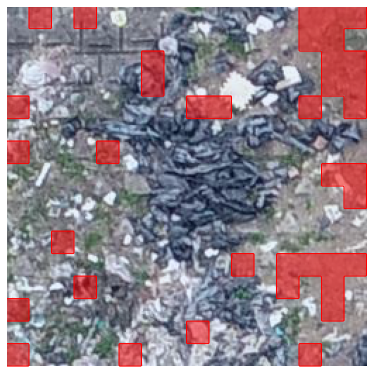

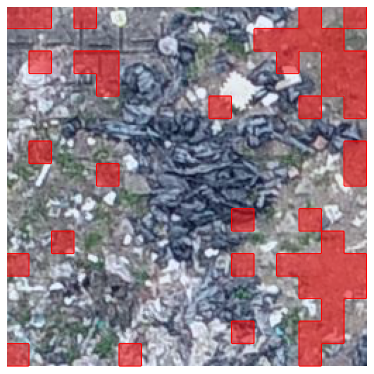

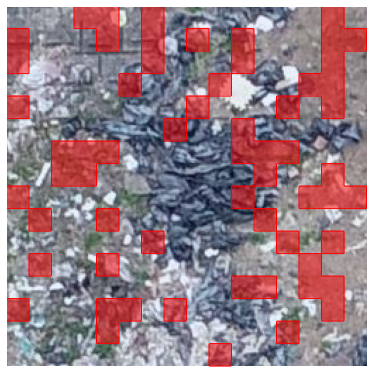

In [30]:
create_attention_maps(d_map) 